In [1]:
TRAIN_EVENTS_PATH = r"/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv"
TRAIN_SERIES_PATH = r"/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet"
TEST_SERIES_PATH = r"/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet"
SAMPLE_SUBMISSION_PATH = r"/kaggle/input/child-mind-institute-detect-sleep-states/sample_submission.csv"

In [2]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm  # for training's progress bar
import torch
from torch import nn,Tensor
from torch.utils.data import Dataset, DataLoader
from scipy.signal import find_peaks
from torch.optim.lr_scheduler import CosineAnnealingLR

import metric as mapmetric # You should have the metric notebook connected; it should connect automatically

In [3]:
train_series = pl.read_parquet(TRAIN_SERIES_PATH)
train_events = pl.read_csv(TRAIN_EVENTS_PATH)
train_events = train_events.with_columns(pl.col("event").replace({"onset":1, "wakeup":-1}, return_dtype=pl.Float32))

# Pre-processing

In [4]:
dfs = []

for series_id, series in train_series.group_by(["series_id"]):
    series = (
        series
        .join(train_events.filter(pl.col('series_id')==series_id), on='timestamp', how='left')
        .with_columns(pl.col('timestamp').str.to_datetime(),
                      pl.col('event').fill_null(0))
    ).to_pandas()
    
    dict_agg = {"series_id": "first", "step": "median", "event": "sum",
                "anglez": ["std", "mean", "min", "max", "first", "last"],
                "enmo": ["std", "mean", "min", "max", "first", "last"]}
    rename = {'series_id_first': 'series_id', 'step_median': 'step', 'event_sum': 'event', 'timestamp_median': 'timestamp'}
    df_1min = series.resample('1min', on='timestamp').agg(dict_agg)
    df_1min.columns = ['_'.join(col) for col in df_1min.columns]  # flatten 2d column index
    df_1min = df_1min.rename(columns=rename).reset_index()  # index was timestamp, now it is a column
    df_1min['step'] = df_1min['step'].apply(int)  # for some reason, median returns halves
    
    df_1min['date'] = df_1min['timestamp'].dt.date
    df_1min['time'] = df_1min['timestamp'].dt.time
    
    values_event = df_1min["event"].values
    values_target = values_event.copy()  # values_target will be the modified target
    for j in range(30):  # symmetry exponential smoothing
        weight = np.exp(-j/2.8)
        values_target[:-(j+1)] += weight*values_event[(j+1):]  # shift backward
        if j > 0:
            values_target[j:] += weight*values_event[:-j]  # shift forward
    df_1min["target"] = values_target
    
    dfs.append(df_1min)
del train_series

In [5]:
X_cols = ["enmo_first", "enmo_last", "enmo_min", "enmo_max", "enmo_mean", "enmo_std",
          "anglez_first", "anglez_last", "anglez_min", "anglez_max", "anglez_mean", "anglez_std"]
dfs_1min = pd.concat(dfs)
dfs_1min

,timestamp,series_id,step,event,anglez_std,anglez_mean,anglez_min,anglez_max,anglez_first,anglez_last,enmo_std,enmo_mean,enmo_min,enmo_max,enmo_first,enmo_last,date,time,target
0,2017-10-04 17:00:00+00:00,35826366dfc7,5,0.0,20.349136,21.868408,-0.273000,68.860001,-0.273000,13.247700,0.032186,0.143483,0.0852,0.2059,0.1476,0.1386,2017-10-04,17:00:00,0.0
1,2017-10-04 17:01:00+00:00,35826366dfc7,17,0.0,21.856596,29.082949,-6.329200,60.535301,26.027599,-6.329200,0.039253,0.133867,0.0806,0.2106,0.1009,0.1625,2017-10-04,17:01:00,0.0
2,2017-10-04 17:02:00+00:00,35826366dfc7,29,0.0,27.069872,3.011450,-38.428699,69.469398,1.693100,9.864700,0.043466,0.079500,0.0285,0.1624,0.0942,0.1322,2017-10-04,17:02:00,0.0
3,2017-10-04 17:03:00+00:00,35826366dfc7,41,0.0,26.041019,14.598392,-17.592600,48.135101,-16.351500,2.611800,0.047438,0.048350,0.0001,0.1532,0.1532,0.0863,2017-10-04,17:03:00,0.0
4,2017-10-04 17:04:00+00:00,35826366dfc7,53,0.0,12.594662,-2.882517,-26.155399,24.253500,24.253500,-26.155399,0.039709,0.100492,0.0390,0.1750,0.0775,0.1066,2017-10-04,17:04:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40195,2019-02-11 18:40:00+00:00,d3dddd3c0e00,482345,0.0,3.717482,-23.459517,-30.400499,-18.195299,-18.195299,-24.640400,0.005942,0.039650,0.0297,0.0526,0.0341,0.0416,2019-02-11,18:40:00,0.0
40196,2019-02-11 18:41:00+00:00,d3dddd3c0e00,482357,0.0,4.861463,-20.253092,-28.160500,-11.240100,-16.025700,-21.047001,0.004878,0.040550,0.0327,0.0525,0.0438,0.0525,2019-02-11,18:41:00,0.0
40197,2019-02-11 18:42:00+00:00,d3dddd3c0e00,482369,0.0,4.747733,-16.778133,-22.879700,-6.569800,-20.325899,-16.093800,0.007592,0.040867,0.0317,0.0556,0.0327,0.0409,2019-02-11,18:42:00,0.0
40198,2019-02-11 18:43:00+00:00,d3dddd3c0e00,482381,0.0,1.720939,-19.780565,-22.826099,-15.897500,-20.071699,-20.606800,0.009311,0.041100,0.0298,0.0593,0.0593,0.0426,2019-02-11,18:43:00,0.0


In [6]:
class SleepDatasetTrain(torch.utils.data.Dataset):
    def __init__(self, dfs_1min, start=0, end=None):
        self.dfs_1min = dfs_1min
        self.dfs = self._init_data(dfs_1min)
        if end is None: self.dfs = self.dfs[start:]
        else: self.dfs = self.dfs[start:end]
        self.series_ids = self._init_series_ids()
        
    def __len__(self):
        return len(self.dfs)

    def __getitem__(self, i):
        df = self.dfs[i]
        X = torch.Tensor(df[X_cols].to_numpy())
        X = (X - X.min()) / (X.max() - X.min())
        X = torch.transpose(X, 0, 1)  # n_features x seq_len
        Y = torch.Tensor(df['target'].to_numpy())  # seq_len
        return X, Y
    
    def _init_data(self, dfs_1min):
        dfs = []
        for (series_id, date), df in dfs_1min.groupby(by=['series_id', 'date']):
            if len(df) == 1440: dfs.append(df)
            else:  # need to pad to a whole day with 0s at every column
                date = df['date'].iloc[0]
                time_range = pd.date_range(start=pd.Timestamp(date), end=pd.Timestamp(date) + pd.Timedelta(days=1) - pd.Timedelta(minutes=1),
                                           freq='min', tz='UTC')
                df_all_times = pd.DataFrame({'timestamp': time_range})
                df = pd.merge(df_all_times, df, on='timestamp', how='left').fillna(0)
                dfs.append(df)
        return dfs
    
    def _init_series_ids(self):
        series_ids = []
        for df in self.dfs:
            series_ids.extend(df['series_id'].unique().tolist())
        return set(series_ids)

# The model 

In [7]:
# Model
#U-Net
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.0):
        super(TransformerEncoder, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.layer_norm2 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs, mask=None):
        # MultiHead Attention
        x, _ = self.multihead_attn(inputs, inputs, inputs, attn_mask=mask)

        # Residual connection with LayerNormalization and Scaling
        x = self.layer_norm1(x + inputs) * (0.5 ** 0.5)

        # Feed Forward Part
        ff = self.ffn(x)
        ff = self.dropout(ff)

        # Residual connection with LayerNormalization and Scaling for FFN
        x = self.layer_norm2(ff + x) * (0.5 ** 0.5)

        return x

    
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, device='cpu'):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, device=device),
                                  nn.BatchNorm1d(out_channels, device=device),
                                  nn.ReLU(),
                                  nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, device=device),
                                  nn.BatchNorm1d(out_channels, device=device),
                                  nn.ReLU())
    
    def forward(self, x):
        return self.conv(x)

    
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=15, stride=1, padding=7, device='cpu'):
        super().__init__()
        se_ratio=4
        self.conv = DoubleConv(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, device=device)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2) # Decreasing the spatial dimensions
        self.conv_post = nn.Sequential(nn.Conv1d(out_channels, out_channels//se_ratio, kernel_size=1, device=device),
            nn.ReLU(),
            nn.Conv1d(out_channels//se_ratio, out_channels, kernel_size=1, device=device),
            nn.Sigmoid())

    
    def forward(self, x):
        conv = self.conv(x)
        pool = self.pool(conv)
        conv2 = self.conv_post(pool)
        return conv, conv2

    
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, up_kernel_size=2, up_stride=2, up_padding=0, kernel_size=15, stride=1, padding=7, device='cpu'):
        super().__init__()
        self.deconv = nn.ConvTranspose1d(in_channels=in_channels, out_channels=out_channels, kernel_size=up_kernel_size, stride=up_stride, padding=up_padding, device=device)
        self.conv = DoubleConv(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, device=device)
    
    def forward(self, x1, x2):
        x1 = self.deconv(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels, num_classes, device='cpu'):
        super().__init__()
        self.down1 = DownSample(in_channels=in_channels, out_channels=64, device=device)
        self.down2 = DownSample(in_channels=64, out_channels=128, device=device)
        self.down3 = DownSample(in_channels=128, out_channels=256, device=device)
        self.bottleneck = DoubleConv(in_channels=256, out_channels=512, device=device)
        self.transformer_bottleneck = TransformerEncoder(embed_dim= 180, num_heads=6, ff_dim=256, dropout=0)
        self.gru = nn.GRU(512, 512, batch_first=True, num_layers=1, device=device)
        self.up3 = UpSample(in_channels=512, out_channels=256, device=device)
        self.up2 = UpSample(in_channels=256, out_channels=128, device=device)
        self.up1 = UpSample(in_channels=128, out_channels=64, device=device)
        self.out = nn.Conv1d(in_channels=64, out_channels=num_classes, kernel_size=1, stride=1, padding=0, device=device)
    
    def forward(self, x, h=None):
        down1, pool = self.down1(x)
        down2, pool = self.down2(pool)
        down3, pool = self.down3(pool)
        bn_res = self.bottleneck(pool)
        ts_res = self.transformer_bottleneck(bn_res)
        bn_res, h = self.gru(torch.transpose(ts_res, 1, 2))
        bn_res = torch.transpose(bn_res, 1, 2)
        up3 = self.up3(bn_res, down3)
        up2 = self.up2(up3, down2)
        up1 = self.up1(up2, down1)
        out = self.out(up1)
        return out, h

# The training loop

Epoch 0 train loss = 0.001295835578400625
Epoch 1 train loss = 0.0007370998421644692
Epoch 2 train loss = 0.0006850389601398364
Epoch 3 train loss = 0.000651127962945571
Epoch 4 train loss = 0.0006083881225896456
Epoch 5 train loss = 0.0005803582966305185
Epoch 6 train loss = 0.0005530679903490113
Epoch 7 train loss = 0.0005234971332083238
Epoch 8 train loss = 0.0005048179371388063
Epoch 9 train loss = 0.000487626981879738


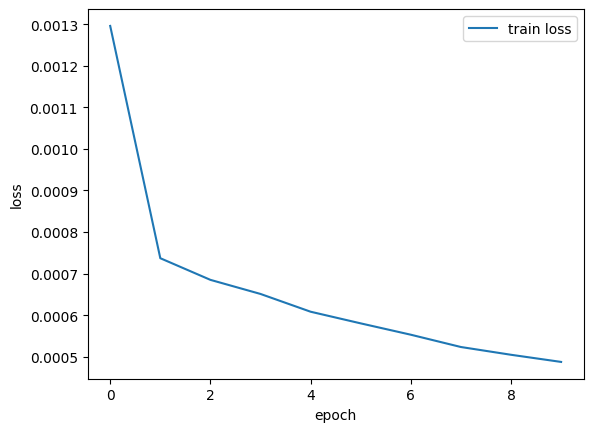

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = UNet(in_channels=len(X_cols), num_classes=1, device=device)  # regression, only 1 feature
net.to(device)

# Training Parameters
EPOCHS =10
loss_func = nn.HuberLoss(delta=0.3)
lr = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Initialize the scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Training metadata
train_loss_history = []
valid_loss_history = []

# data management
batch_size = 4
series_ids = dfs_1min['series_id'].unique()
train_series_ids = series_ids
# valid_series_ids = series_ids[200:]
train_ds = SleepDatasetTrain(dfs_1min[dfs_1min['series_id'].isin(train_series_ids)])
# valid_ds = SleepDatasetTrain(dfs_1min[dfs_1min['series_id'].isin(valid_series_ids)])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_ds, batch_size=batch_size)

# training loop
for epoch in range(EPOCHS):
    net.train()
    epoch_loss = 0    
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        pred, h = net(X_batch.to(device))
        pred = pred.squeeze(1)
        loss = loss_func(pred.float(), Y_batch.to(device).float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch} train loss = {epoch_loss / len(train_loader)}')
    train_loss_history.append(epoch_loss / len(train_loader))
    scheduler.step()

plt.plot(list(range(EPOCHS)), train_loss_history, label="train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

# Pre-processing the test data

In [9]:
test_series = pl.read_parquet(TEST_SERIES_PATH)
test_dfs = []

for series_id, series in test_series.group_by(["series_id"]):
    series = (
        series
        .with_columns(pl.col('timestamp').str.to_datetime())
    ).to_pandas()
    
    dict_agg = {"series_id": "first", "step": "median",
                "anglez": ["std", "mean", "min", "max", "first", "last"],
                "enmo": ["std", "mean", "min", "max", "first", "last"]}
    rename = {'series_id_first': 'series_id', 'step_median': 'step', 'timestamp_median': 'timestamp'}
    df_1min = series.resample('1min', on='timestamp').agg(dict_agg)
    df_1min.columns = ['_'.join(col) for col in df_1min.columns]  # flatten 2d column index
    df_1min = df_1min.rename(columns=rename).reset_index()  # index was timestamp, now it is a column
    df_1min['step'] = df_1min['step'].apply(int)  # for some reason, median returns halves
    
    df_1min['date'] = df_1min['timestamp'].dt.date
    df_1min['time'] = df_1min['timestamp'].dt.time
    
    df_1min['target'] = 0  # not using this, just to avoid error
    
    test_dfs.append(df_1min)
del test_series

In [10]:
test_df = pd.concat(test_dfs)
test_df

,timestamp,series_id,step,anglez_std,anglez_mean,anglez_min,anglez_max,anglez_first,anglez_last,enmo_std,enmo_mean,enmo_min,enmo_max,enmo_first,enmo_last,date,time,target
0,2018-05-31 16:00:00+00:00,03d92c9f6f8a,5,45.274117,15.517041,-77.440102,60.486698,38.892899,-69.170998,0.045621,0.070150,0.0077,0.1791,0.0803,0.0077,2018-05-31,16:00:00,0
1,2018-05-31 16:01:00+00:00,03d92c9f6f8a,17,34.798382,-48.820648,-88.042000,50.356400,-60.316101,-88.042000,0.016994,0.011108,0.0000,0.0405,0.0000,0.0133,2018-05-31,16:01:00,0
2,2018-05-31 16:02:00+00:00,03d92c9f6f8a,29,0.049751,-88.225128,-88.367996,-88.147499,-88.147499,-88.216599,0.004578,0.002458,0.0000,0.0114,0.0114,0.0000,2018-05-31,16:02:00,0
3,2018-05-31 16:03:00+00:00,03d92c9f6f8a,41,0.000000,-88.216591,-88.216599,-88.216599,-88.216599,-88.216599,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,2018-05-31,16:03:00,0
4,2018-05-31 16:04:00+00:00,03d92c9f6f8a,53,0.000000,-88.216591,-88.216599,-88.216599,-88.216599,-88.216599,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,2018-05-31,16:04:00,0
5,2018-05-31 16:05:00+00:00,03d92c9f6f8a,65,0.000000,-88.216591,-88.216599,-88.216599,-88.216599,-88.216599,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,2018-05-31,16:05:00,0
6,2018-05-31 16:06:00+00:00,03d92c9f6f8a,77,0.000000,-88.216591,-88.216599,-88.216599,-88.216599,-88.216599,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,2018-05-31,16:06:00,0
7,2018-05-31 16:07:00+00:00,03d92c9f6f8a,89,0.000000,-88.216591,-88.216599,-88.216599,-88.216599,-88.216599,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,2018-05-31,16:07:00,0
8,2018-05-31 16:08:00+00:00,03d92c9f6f8a,101,0.000000,-88.216591,-88.216599,-88.216599,-88.216599,-88.216599,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,2018-05-31,16:08:00,0
9,2018-05-31 16:09:00+00:00,03d92c9f6f8a,113,0.000000,-88.216591,-88.216599,-88.216599,-88.216599,-88.216599,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,2018-05-31,16:09:00,0


In [11]:
test_ds = SleepDatasetTrain(test_df)

# Post processing and making the submission

In [12]:
rows = []
net.eval()
for i, (x, y) in tqdm(enumerate(test_ds), total=len(test_ds)):
    with torch.no_grad():
        df = test_ds.dfs[i]
        series_id = 0
        for ser_id in df['series_id']:
            if ser_id != 0:
                series_id = ser_id
                break
        if series_id == 0: continue
        test_pred, h = net(x.to(device).unsqueeze(0))
        test_pred = test_pred.squeeze(1).cpu()[0]  # shape was 1x1440 because batch size was 1
        for event in ('onset', 'wakeup'):
            test_pred = test_pred if event == 'onset' else -1*test_pred
            peak_idxs = find_peaks(test_pred, height=0.01, distance=8)[0]
            for peak_idx in peak_idxs:
                step = df['step'].iloc[peak_idx]
                if step == 0: continue
                score = test_pred[peak_idx].item()
                rows.append({'series_id': series_id, 'step': step, 'event': event, 'score': round(score, 3)})
preds_df = pd.DataFrame(rows)
if not preds_df.empty:
    preds_df['step'] = preds_df['step'].astype(int)
    preds_df['row_id'] = preds_df.index
    preds_df = preds_df[['row_id', 'series_id', 'step', 'event', 'score']]
else:
    preds_df = pd.DataFrame(columns=['row_id', 'series_id', 'step', 'event', 'score'])
preds_df.to_csv('submission.csv', index=False)
preds_df

  0%|          | 0/3 [00:00<?, ?it/s]

,row_id,series_id,step,event,score
0,0,0402a003dae9,146,onset,0.015


In [13]:
test_series = pl.read_parquet(TEST_SERIES_PATH)